# 10. PCA

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import *
rcParams['figure.figsize'] = (7, 7)
font = {'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)
from IPython.core.display import HTML
css_file = '../my.css'
HTML(open(css_file, "r").read())

PCA decomposes a data set in its **principal components** (PC) through a linear transformation. Principal components (also called *eigenvectors*) are orthogonal to each other and point in the direction of **largest variance**, i.e. they retain the most information of the data set.

So what does *point in the direction of largest variance* mean? Let's say we have a data set with two dimensions (features) and we want to reduce each data point to one dimension:

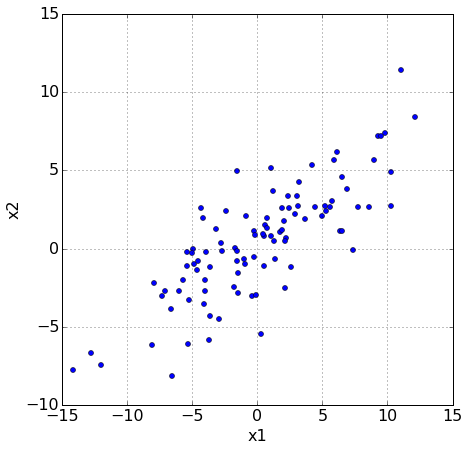

In [2]:
data = pd.read_csv('pca.csv',sep=',')

plt.plot(data['x1'],data['x2'],'bo',markersize=5)
plt.grid()
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

To apply PCA the data needs to be **centered** (mean=0) first! In this case it was centered already. In scikit-learn you can center the data with the *StandardScaler* object:

In [3]:
#from sklearn.preprocessing import StandardScaler
#data_std = StandardScaler().fit_transform(data)

PCA will search for the direction that preserves the most of the original variance. This is the red Eigenvector 1 in the plot below:

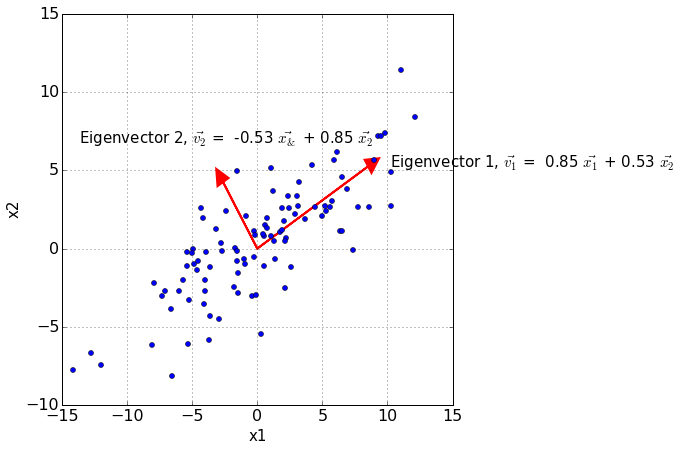

In [4]:
w,v=eig(cov(data.values.T)) #finds the eigenvalues and principle components (eigenvectors)

plt.plot(data['x1'],data['x2'],'bo',markersize=5)
plt.arrow(0,0,10*v[0,0],10*v[1,0],color='r',linewidth=2,head_width=1,head_length=1)
plt.arrow(0,0,5*v[0,1],5*v[1,1],color='r',linewidth=2,head_width=1,head_length=1)
plt.text(12*v[0,0],10*v[1,0],r'Eigenvector 1, $\vec{v_1}$ =  %.2f $\vec{x_1}$ + %.2f $\vec{x_2}$' % (v[0,0],v[1,0]), fontsize=15)
plt.text(26*v[0,1],8*v[1,1],r'Eigenvector 2, $\vec{v_2}$ =  %.2f $\vec{x_&}$ + %.2f $\vec{x_2}$' % (v[0,1],v[1,1]), fontsize=15)
plt.xlabel('x1',fontsize=15)
plt.ylabel('x2',fontsize=15)
plt.grid()
plt.show()

The second principle component is orthogonal to Eigenvector 1 and is shown as the red Eigenvector 2. Each $i$-th principle component has an **eigenvalue** $w_i$ that represents the variance observed for the corresponding principle component:

In [5]:
print "Eigenvalue for Eigenvector 1 (w_0): %.2f" % (w[0])
print "Eigenvalue for Eigenvector 2 (w_1): %.2f" % (w[1])

Eigenvalue for Eigenvector 1 (w_0): 38.81
Eigenvalue for Eigenvector 2 (w_1): 3.48


The amount of **variance explained** by each PC is given by

$$\text{Variance explained by PC i}=\frac{w_i}{\sum_j w_j}.$$


In [6]:
var_explained=100*w/sum(w)
print "Variance explained by PC 1: %f" % var_explained[0]
print "Variance explained by PC 2: %f" % var_explained[1]

Variance explained by PC 1: 91.775895
Variance explained by PC 2: 8.224105


The first principle component does indeed explains much more of the original variance in the data set. This means we can remove dimension PC 2 and project the data on PC 1. From the plot above we know that we can compute the data points for PC 1 from the original features $x_1$ and $x_2$ as

$$\vec{v_1} =  0.85 \vec{x_1} + 0.53 \vec{x_2}.$$

We now replaced the features $x_1$ and $x_2$ by the feature $v_1$. This one dimensional data set can be plotted as a histogram:

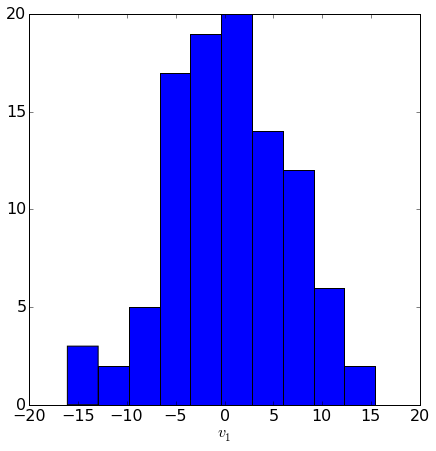

In [7]:
plt.hist(v[0,0]*data['x1']+v[1,0]*data['x2'])
plt.xlabel('$v_1$')
plt.show()

The variance of this distribution is thus 38.81.

To show how PCA is applied using the PCA object in scikit learn we first create an artificial data set with 100 samples in two classes. There are 100 features of which 10 are informative:

In [8]:
import sklearn.datasets as datasets

(data,targets) = datasets.make_classification(
n_samples=100,
n_features=100,
n_classes=2,
n_informative=10,
n_redundant=0,
n_repeated=0,
class_sep=2,
n_clusters_per_class=1,
random_state=2,
)

Now we apply PCA an keep only the two top principle components. The data set is projected (or transformed) onto these two new dimensions and plotted:

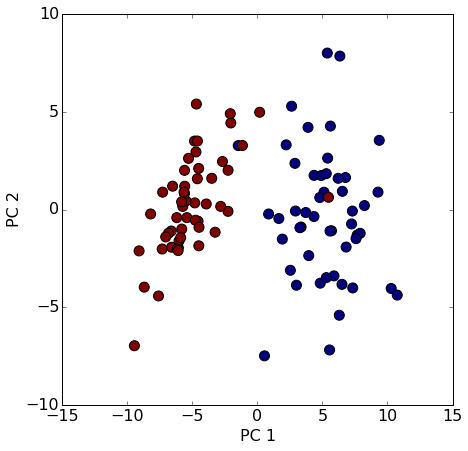

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_p = pca.fit(data).transform(data)

plt.scatter(data_p[:,0],data_p[:,1],c=targets,s=100)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

The plots reveals the two classes (remember these were not known to the PCA algorithm) and also reveals possible outliers in both classes. We can look at the explained variance for each PC:

In [10]:
print "Variance explained by PC 1: %f" % pca.explained_variance_ratio_[0]
print "Variance explained by PC 2: %f" % pca.explained_variance_ratio_[1]

Variance explained by PC 1: 0.214116
Variance explained by PC 2: 0.056570


We observe how PC 1 and 2 together only explain about 27% of the original variance.

To better understand what PCA is actually doing we will apply it to the task of image recognition. Images are typically represented by there pixel values. For high resolution images the number of features can become very large. PCA can be applied to reduce the number of features while preserving most of the information in the data set.

We first load a data set than contains 1288 images with each 50x37=1850 grey-scale pixels. Each image is a face of one of seven persons:

In [13]:
from sklearn.datasets import fetch_lfw_people

h=50
w=37

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw_people.data
n_samples, n_features = X.shape

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)



Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


This function allows us to plot these faces:

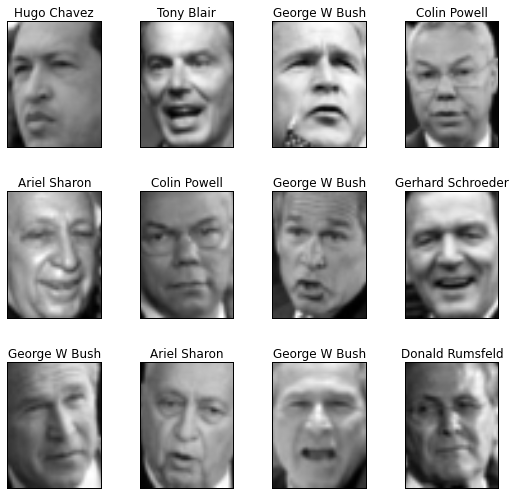

In [14]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

        
plot_gallery(X, target_names[y], h, w)

Let's say we want to reduce the 1850 dimensions for each image to 150 using PCA:

In [15]:
n_components = 150
pca = PCA(n_components=n_components).fit(X)

Now we can take a look at the top 12 principle components (remember that these are vectors on which the images are projected): 

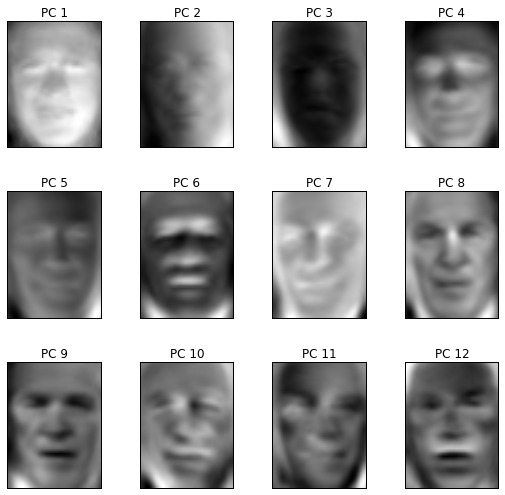

In [16]:
eigenfaces = pca.components_.reshape((n_components, h, w))

eigenface_titles = ["PC %d" % (int(i)+1) for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

Each of these PCs (150 in total) is a feature in the new data set computed from the original 1850 features. We can now use these 150 PCs to project the images:

In [17]:
X_pca = pca.transform(X)

(1288L, 150L)
(150L, 1850L)


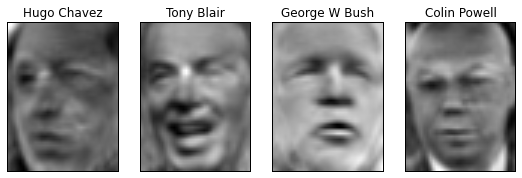

In [18]:
X_reconstructed = np.dot(X_pca, pca.components_)
print X_pca.shape
print pca.components_.shape
plot_gallery(X_reconstructed, target_names[y], h, w, n_row=1)

In [ ]:
plot_gallery(X, target_names[y], h, w, n_row=1)

Multidimensional scaling (MDS) seeks a low-dimensional representation of the data in which the low-dimensional distances respect well the distances in the original high-dimensional space.

In general, it is a technique used for analyzing similarity or dissimilarity data. The algorithm starts from **distance matrix** rather then from a data set with feature vectors. This distance matrix contains the distances (dissimilarity) between the objects in a data set (e.g. interaction frequencies of molecules). So we don't necessarely have to represent the objects in the data set as feature vectors.

Let $\delta_{i,j}$ be the distance between object $i$ and object $j$ in the data set with $n$ objects. The distance matrix $\Delta$ can the be written as


\begin{pmatrix}
\delta_{1,1} & \delta_{1,2} & \cdots & \delta_{1,n} \\
\delta_{2,1} & \delta_{2,2} & \cdots & \delta_{2,n} \\
\vdots & \vdots & & \vdots \\
\delta_{n,1} & \delta_{n,2} & \cdots & \delta_{n,n}
\end{pmatrix}


The goal of MDS is, given $\Delta$, to find $n$ vectors $x_1,\ldots,x_n \in \mathbb{R}^N$ such that

$$\|x_i - x_j\| \approx \delta_{i,j}$$ 

for all 

$$i,j\in {1,\dots,n},$$

where $\|\cdot\|$ is a vector norm. In classical MDS, this norm is the Euclidean distance, but it may be any metric or arbitrary distance function.

Let's look at a typical example in which we don't want (or can't) represent the objects in the data set as feature vectors. Imagine we have collected car gps tracking data and used it to compute a distance matrix $\Delta$ in which the distance between two US cities is estimated by the average time a car required to travel between the cities. 

In this case we will be reading a distance matrix:

In [19]:
Delta = pd.read_csv('cities_us.csv',sep=' ')
Delta

Atlanta  Chicago  Denver  Houston     LA  Miami    NYC     SF  Seattle  \
0    0.000    0.587   1.212    0.701  1.936  0.604  0.748  2.139    2.182   
1    0.587    0.000   0.920    0.940  1.745  1.188  0.713  1.858    1.737   
2    1.212    0.920   0.000    0.879  0.831  1.726  1.631  0.949    1.021   
3    0.701    0.940   0.879    0.000  1.374  0.968  1.420  1.645    1.891   
4    1.936    1.745   0.831    1.374  0.000  2.339  2.451  0.347    0.959   
5    0.604    1.188   1.726    0.968  2.339  0.000  1.092  2.594    2.734   
6    0.748    0.713   1.631    1.420  2.451  1.092  0.000  2.571    2.408   
7    2.139    1.858   0.949    1.645  0.347  2.594  2.571  0.000    0.678   
8    2.182    1.737   1.021    1.891  0.959  2.734  2.408  0.678    0.000   
9    0.543    0.597   1.494    1.225  2.500  0.923  0.205  2.442    2.329   

      DC  
0  0.543  
1  0.597  
2  1.494  
3  1.225  
4  2.500  
5  0.923  
6  0.205  
7  2.442  
8  2.329  
9  0.000

MDS will plot these distances on a 2D map such that cities that require longer average driving times are positioned further away in the map. We should thus be able to reconstruct the US map:

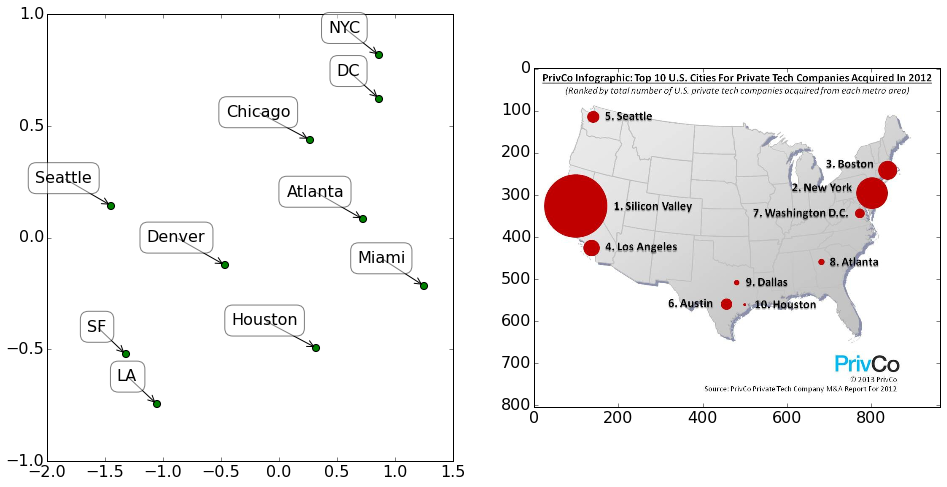

In [20]:
from sklearn import manifold
import matplotlib.image as mpimg

img=mpimg.imread('map_graphic_965.jpg')

similarities = Delta.values

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=2,
                   dissimilarity="precomputed", n_jobs=1)
mds_pos = mds.fit(similarities).embedding_

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(mds_pos[:, 0], mds_pos[:, 1], s=50, c='g')
for label, (x, y) in enumerate(zip(mds_pos[:, 0], mds_pos[:, 1])):
    plt.annotate(
        Delta.columns.values[label], 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.subplot(1,2,2)
imgplot = plt.imshow(img)
plt.show()

We can see that the relative distances between the cities in the map are indeed correct. However, the map is rotated compared to the real map of the US. This is because the algorithm that computes the MDS coordinates starts with a random initialization of its model parameters, so every time you run MDS you well get a different rotation of the data. The MDS coordinates thus have no meaning other then representing distances between objects.